<h1>The Variational Quantum Linear Solver</h1>

In [1]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
import math
import random
import numpy as np
from scipy.optimize import minimize
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

**Introduction**

The Variational Quantum Linear Solver, or the VQLS is a variational quantum algorithm that utilizes VQE in order to solve systems of linear equations more efficiently than classical computational algortihms. Specifically, if we are given some matrix $\textbf{A}$, such that $\textbf{A} |\textbf{x}\rangle \ = \ |\textbf{b}\rangle$, where $|\textbf{b}\rangle$ is some known vector, the VQLS algorithm is theoretically able to find a normalized $|x\rangle$ that is proportional to $|\textbf{x}\rangle$, which makes the above relationship true.

The output of this algorithm is identical to that of the HHL Quantum Linear-Solving Algorithm, except, while HHL provides a much more favourable computation speedup over VQLS, the variational nature of our algorithm allows for it to be performed on NISQ quantum computers, while HHL would require much more robust quantum hardware, and many more qubits.


**The Algorithm**

To begin, the inputs into this algorithm are evidently the matrix $\textbf{A}$, which we have to decompose into a linear combination of unitaries with complex coefficients:



$$A \ = \ \displaystyle\sum_{n} c_n \ A_n$$



Where each $A_n$ is some unitary, and some unitary $U$ that prepares state $|\textbf{b}\rangle$ from $|0\rangle$. Now, recall the general structure of a variational quantum algorithm. We have to construct a quantum cost function, which can be evaluated with a low-depth parametrized quantum circuit, then output to the classical optimizer. This allows us to search a parameter space for some set of parameters $\alpha$, such that $|\psi(\alpha)\rangle \ = \ \frac{|\textbf{x}\rangle}{|| \textbf{x} ||}$, where $|\psi(k)\rangle$ is the output of out quantum circuit corresponding to some parameter set $k$.

Before we actually begin constructing the cost function, let's take a look at a "high level" overview of the sub-routines within this algorithm, as illustrated in this image from the original paper:

![alt text](images/bro.png)

So essentially, we start off with a qubit register, with each qubit initialized to $|0\rangle$. Our algorithm takes its inputs, then prepares and evaluates the cost function, starting with the creation of some ansatz $V(\alpha)$. If the computed cost is greater than some parameter $\gamma$, the algorithm is run again with updated parameters, and if not, the algorithm terminates, and the ansatz is calculated with the optimal parameters (determined at termination). This gives us the state vector that minimizes our cost function, and therefore the normalized form of $|\textbf{x}\rangle$.

Let's start off by considering the ansatz $V(\alpha)$, which is just a circuit that prepares some arbitrary state $|\psi(k)\rangle$. This allows us to "search" the state space by varying some set of parameters, $k$. Anyways, the ansatz that we will use for this implementation is given as follows:

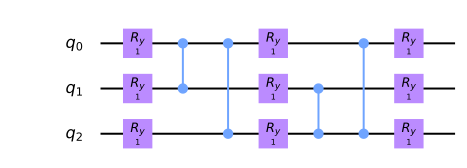

In [2]:
def apply_fixed_ansatz(qubits, parameters):

    for iz in range (0, len(qubits)):
        circ.ry(parameters[0][iz], qubits[iz])

    circ.cz(qubits[0], qubits[1])
    circ.cz(qubits[2], qubits[0])

    for iz in range (0, len(qubits)):
        circ.ry(parameters[1][iz], qubits[iz])

    circ.cz(qubits[1], qubits[2])
    circ.cz(qubits[2], qubits[0])

    for iz in range (0, len(qubits)):
        circ.ry(parameters[2][iz], qubits[iz])

circ = QuantumCircuit(3)
apply_fixed_ansatz([0, 1, 2], [[1, 1, 1], [1, 1, 1], [1, 1, 1]])
circ.draw(output='mpl')

This is called a **fixed hardware ansatz**: the configuration of quantum gates remains the same for each run of the circuit, all that changes are the parameters. Unlike the QAOA ansatz, it is not composed solely of Trotterized Hamiltonians. The applications of $Ry$ gates allows us to search the state space, while the $CZ$ gates create "interference" between the different qubit states. 

Now, it makes sense for us to consider the actual **cost function**. The goal of our algorithm will be to minimize cost, so when $|\Phi\rangle \ = \ \textbf{A} |\psi(k)\rangle$ is very close to $|\textbf{b}\rangle$, we want our cost function's output to be very small, and when the vectors are close to being ortohognal, we want the cost function to be very large. Thus, we introduce the "projection" Hamiltonian:



$$H_P \ = \ \mathbb{I} \ - \ |b\rangle \langle b|$$



Where we have:



$$C_P \ = \ \langle \Phi | H_P | \Phi \rangle \ = \ \langle \Phi | (\mathbb{I} \ - \ |b\rangle \langle b|) |\Phi \rangle \ = \ \langle \Phi | \Phi \rangle \ - \ \langle \Phi |b\rangle \langle b | \Phi \rangle$$



Notice how the second term tells us "how much" of $|\Phi\rangle$ lies along $|b\rangle$. We then subtract this from another number to get the desired low number when the inner product of $|\Phi\rangle$ and $|b\rangle$ is greater (they agree more), and the opposite for when they are close to being orthogonal. This is looking good so far! However, there is still one more thing we can do to increase the accuracy of the algorithm: normalizing the cost function. This is due to the fact that if $|\Phi\rangle$ has a small norm, then the cost function will still be low, even if it does not agree with $|\textbf{b}\rangle$. Thus, we replace $|\Phi\rangle$ with $\frac{|\Phi\rangle}{\sqrt{\langle \Phi | \Phi \rangle}}$:



$$\hat{C}_P \ = \ \frac{\langle \Phi | \Phi \rangle}{\langle \Phi | \Phi \rangle} \ - \ \frac{\langle \Phi |b\rangle \langle b | \Phi \rangle}{\langle \Phi | \Phi \rangle} \ = \ 1 \ - \ \frac{\langle \Phi |b\rangle \langle b | \Phi \rangle}{\langle \Phi | \Phi \rangle} \ = \ 1 \ - \ \frac{|\langle b | \Phi \rangle|^2}{\langle \Phi | \Phi \rangle}$$



Ok, so, we have prepared our state $|\psi(k)\rangle$ with the ansatz. Now, we have two values to calculate in order to evaluate the cost function, namely $|\langle b | \Phi \rangle|^2$ and $\langle \Phi | \Phi \rangle$. Luckily, a nifty little quantum subroutine called the **Hadamard Test** allows us to do this! Essentially, if we have some unitary $U$ and some state $|\phi\rangle$, and we want to find the expectation value of $U$ with respect to the state, $\langle \phi | U | \phi \rangle$, then we can evaluate the following circuit:

<br><br>

![image1](images/h.png)

<br><br>

Then, the probability of measuring the first qubit to be $0$ is equal to $\frac{1}{2} (1 \ + \ \text{Re}\langle U \rangle)$ and the probability of measuring $1$ is $\frac{1}{2} (1 \ - \ \text{Re}\langle U \rangle)$, so subtracting the two probabilities gives us $\text{Re} \langle U \rangle$. Luckily, the matrices we will be dealing with when we test this algorithm are completely real, so $\text{Re} \langle U \rangle \ = \ \langle U \rangle$, for this specific implementation. Here is how the Hadamard test works. By the circuit diagram, we have as our general state vector:

<br>



$$\frac{|0\rangle \ + \ |1\rangle}{\sqrt{2}} \ \otimes \ |\psi\rangle \ = \ \frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ |\psi\rangle}{\sqrt{2}}$$



<br>

Applying our controlled unitay:

<br>



$$\frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ |\psi\rangle}{\sqrt{2}} \ \rightarrow \ \frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ U|\psi\rangle}{\sqrt{2}}$$



<br>

Then applying the Hadamard gate to the first qubit:

<br>



$$\frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ U|\psi\rangle}{\sqrt{2}} \ \rightarrow \ \frac{1}{2} \ \big[ |0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ |\psi\rangle \ + \ |0\rangle \ \otimes \ U|\psi\rangle \ - \ |1\rangle \ \otimes \ U|\psi\rangle \big]$$



<br>



$$\Rightarrow \ |0\rangle \ \otimes \ (\mathbb{I} \ + \ U)|\psi\rangle \ + \ |1\rangle \ \otimes \ (\mathbb{I} \ - \ U)|\psi\rangle$$



<br>

When we take a measurement of the first qubit, remember that in order to find the probability of measuring $0$, we must take the inner product of the state vector with $|0\rangle$, then multiply by its complex conjugate (see the quantum mechanics section if you are not familiar with this). The same follows for the probability of measuring $1$. Thus, we have:

<br>



$$P(0) \ = \ \frac{1}{4} \ \langle \psi | (\mathbb{I} \ + \ U) (\mathbb{I} \ + \ U^{\dagger}) |\psi\rangle \ = \ \frac{1}{4} \ \langle \psi | (\mathbb{I}^2 \ + U \ + \ U^{\dagger} \ + \ U^{\dagger} U) |\psi\rangle \ = \ \frac{1}{4} \ \langle \psi | (2\mathbb{I} \ + U \ + \ U^{\dagger}) |\psi\rangle$$



<br>



$$\Rightarrow \ \frac{1}{4} \Big[ 2 \ + \ \langle \psi | U^{\dagger} | \psi \rangle \ + \ \langle \psi | U | \psi \rangle \Big] \ = \ \frac{1}{4} \Big[ 2 \ + \ (\langle \psi | U | \psi \rangle)^{*} \ + \ \langle \psi | U | \psi \rangle \Big] \ = \ \frac{1}{2} (1 \ + \ \text{Re} \ \langle \psi | U | \psi \rangle)$$



<br>

By a similar procedure, we get:

<br>



$$P(1) \ = \ \frac{1}{2} \ (1 \ - \ \text{Re} \ \langle \psi | U | \psi \rangle)$$



<br>

And so, by taking the difference:

<br>



$$P(0) \ - \ P(1) \ = \ \text{Re} \ \langle \psi | U | \psi \rangle$$



<br>

Cool! Now, we can actually implement this for the two values we have to compute. Starting with $\langle \Phi | \Phi \rangle$, we have:

<br>



$$\langle \Phi | \Phi \rangle \ = \ \langle \psi(k) | A^{\dagger} A |\psi(k) \rangle \ = \ \langle 0 | V(k)^{\dagger} A^{\dagger} A V(k) |0\rangle \ = \ \langle 0 | V(k)^{\dagger} \Big( \displaystyle\sum_{n} c_n \ A_n \Big)^{\dagger} \Big( \displaystyle\sum_{n} c_n \ A_n \Big) V(k) |0\rangle$$



<br>



$$\Rightarrow \ \langle \Phi | \Phi \rangle \ = \ \displaystyle\sum_{m} \displaystyle\sum_{n} c_m^{*} c_n \langle 0 | V(k)^{\dagger} A_m^{\dagger} A_n V(k) |0\rangle$$



<br>

and so our task becomes computing every possible term $\langle 0 | V(k)^{\dagger} A_m^{\dagger} A_n V(k) |0\rangle$ using the Hadamard test. This requires us prepare the state $V(k) |0\rangle$, and then perform controlled operations with some control-ancilla qubit for the unitary matrices $A_m^{\dagger}$ and $A_n$. We can implement this in code:


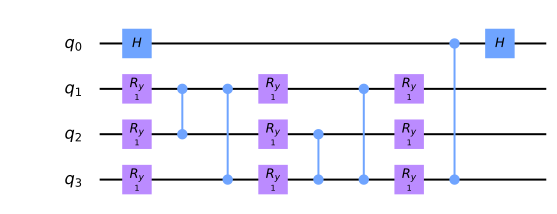

In [3]:
#Creates the Hadamard test

def had_test(gate_type, qubits, ancilla_index, parameters):

    circ.h(ancilla_index)

    apply_fixed_ansatz(qubits, parameters)

    for ie in range (0, len(gate_type[0])):
        if (gate_type[0][ie] == 1):
            circ.cz(ancilla_index, qubits[ie])

    for ie in range (0, len(gate_type[1])):
        if (gate_type[1][ie] == 1):
            circ.cz(ancilla_index, qubits[ie])
    
    circ.h(ancilla_index)
    
circ = QuantumCircuit(4)
had_test([[0, 0, 0], [0, 0, 1]], [1, 2, 3], 0, [[1, 1, 1], [1, 1, 1], [1, 1, 1]])
circ.draw(output='mpl')

The reason why we are applying two different "gate_types" is because this represents the pairs of gates shown in the expanded form of $\langle \Phi | \Phi \rangle$.

It is also important to note that for the purposes of this implementation (the systems of equations we will actually be sovling, we are only concerned with the gates $Z$ and $\mathbb{I}$, so I only include support for these gates (The code includes number "identifiers" that signify the application of different gates, $0$ for $\mathbb{I}$ and $1$ for $Z$).

Now, we can move on to the second value we must calculate, which is $|\langle b | \Phi \rangle|^2$. We get:

<br>



$$|\langle b | \Phi \rangle|^2 \ = \ |\langle b | A V(k) | 0 \rangle|^2 \ = \ |\langle 0 | U^{\dagger} A V(k) | 0 \rangle|^2 \ = \ \langle 0 | U^{\dagger} A V(k) | 0 \rangle \langle 0 | V(k)^{\dagger} A^{\dagger} U |0\rangle$$



<br>

All we have to do now is the same expansion as before for the product $\langle 0 | U^{\dagger} A V(k) | 0 \rangle \langle 0 | V(k)^{\dagger} A^{\dagger} U |0\rangle$:

<br>



$$\langle 0 | U^{\dagger} A V(k) | 0 \rangle^2 \ = \ \displaystyle\sum_{m} \displaystyle\sum_{n} c_m^{*} c_n \langle 0 | U^{\dagger} A_n V(k) | 0 \rangle \langle 0 | V(k)^{\dagger} A_m^{\dagger} U |0\rangle$$



<br>

Now, again, for the purposes of this demonstration, we will soon see that all the outputs/expectation values of our implementation will be real, so we have:
<br>



$$\Rightarrow \ \langle 0 | U^{\dagger} A V(k) | 0 \rangle \ = \ (\langle 0 | U^{\dagger} A V(k) | 0 \rangle)^{*} \ = \ \langle 0 | V(k)^{\dagger} A^{\dagger} U |0\rangle$$



<br>

Thus, in this particular implementation:

<br>



$$|\langle b | \Phi \rangle|^2 \ = \ \displaystyle\sum_{m} \displaystyle\sum_{n} c_m c_n \langle 0 | U^{\dagger} A_n V(k) | 0 \rangle \langle 0 | U^{\dagger} A_m V(k) | 0 \rangle$$



<br>

There is a sophisticated way of solving for this value, using a newly-proposed subroutine called the **Hadamard Overlap Test** (see cited paper), but for this tutorial, we will just be using a standard Hadamard Test, where we control each matrix. This unfortauntely requires the use of an extra ancilla qubit. We essentially just place a control on each of the gates involved in the ancilla, the $|b\rangle$ preparation unitary, and the $A_n$ unitaries. We get something like this for the controlled-ansatz:


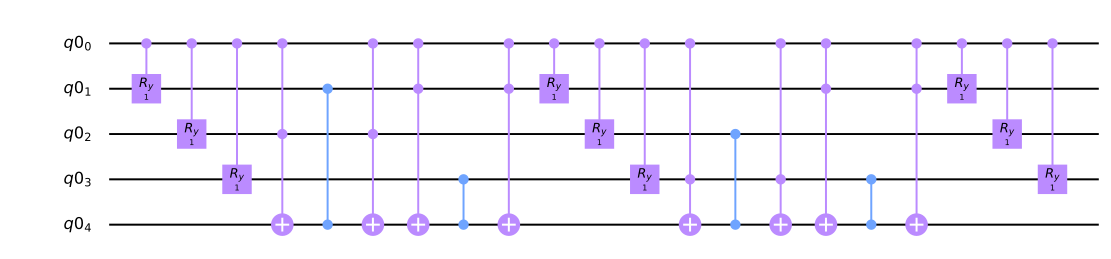

In [4]:
#Creates controlled anstaz for calculating |<b|psi>|^2 with a Hadamard test

def control_fixed_ansatz(qubits, parameters, ancilla, reg):

    for i in range (0, len(qubits)):
        circ.cry(parameters[0][i], qiskit.circuit.Qubit(reg, ancilla), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(ancilla, qubits[1], 4)
    circ.cz(qubits[0], 4)
    circ.ccx(ancilla, qubits[1], 4)

    circ.ccx(ancilla, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(ancilla, qubits[0], 4)

    for i in range (0, len(qubits)):
        circ.cry(parameters[1][i], qiskit.circuit.Qubit(reg, ancilla), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(ancilla, qubits[2], 4)
    circ.cz(qubits[1], 4)
    circ.ccx(ancilla, qubits[2], 4)

    circ.ccx(ancilla, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(ancilla, qubits[0], 4)

    for i in range (0, len(qubits)):
        circ.cry(parameters[2][i], qiskit.circuit.Qubit(reg, ancilla), qiskit.circuit.Qubit(reg, qubits[i]))

q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
control_fixed_ansatz([1, 2, 3], [[1, 1, 1], [1, 1, 1], [1, 1, 1]], 0, q_reg)
circ.draw(output='mpl')

Notice the extra qubit, `q0_4`. This is an ancilla, and allows us to create a $CCZ$ gate, as is shown in the circuit. Now, we also have to create the circuit for $U$. In our implementation, we will pick $U$ as:

<br>



$$U \ = \ H_1 H_2 H_3$$



<br>

Thus, we have:

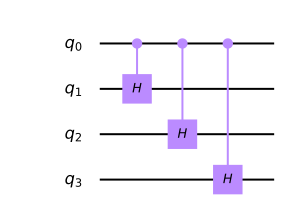

In [5]:
def control_b(ancilla, qubits):

    for ia in qubits:
        circ.ch(ancilla, ia)

circ = QuantumCircuit(4)
control_b(0, [1, 2, 3])
circ.draw(output='mpl')

Finally, we construct our new Hadamard test:

In [6]:
#Create the controlled Hadamard test, for calculating <psi|psi>

def special_had_test(gate_type, qubits, ancilla_index, parameters, reg):

    circ.h(ancilla_index)

    control_fixed_ansatz(qubits, parameters, ancilla_index, reg)

    for ty in range (0, len(gate_type)):
        if (gate_type[ty] == 1):
            circ.cz(ancilla_index, qubits[ty])


    control_b(ancilla_index, qubits)
    
    circ.h(ancilla_index)

q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
special_had_test([[0, 0, 0], [0, 0, 1]], [1, 2, 3], 0, [[1, 1, 1], [1, 1, 1], [1, 1, 1]], q_reg)
print(circ)

      ┌───┐                                                              »
q1_0: ┤ H ├────■────────■────────■──────■───────■────■───────■──────■────»
      └───┘┌───┴───┐    │        │      │       │    │       │  ┌───┴───┐»
q1_1: ─────┤ RY(1) ├────┼────────┼──────┼───■───┼────■───────■──┤ RY(1) ├»
           └───────┘┌───┴───┐    │      │   │   │    │       │  └───────┘»
q1_2: ──────────────┤ RY(1) ├────┼──────■───┼───■────┼───────┼───────────»
                    └───────┘┌───┴───┐  │   │   │    │       │           »
q1_3: ───────────────────────┤ RY(1) ├──┼───┼───┼────┼───■───┼───────────»
                             └───────┘┌─┴─┐ │ ┌─┴─┐┌─┴─┐ │ ┌─┴─┐         »
q1_4: ────────────────────────────────┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├─────────»
                                      └───┘   └───┘└───┘   └───┘         »
«                                                                             »
«q1_0: ────■────────■──────■───────■────■───────■──────■────────■────────■────»
«          │   

This is for the specific implementation when all of our parameters are set to $1$, and the set of gates $A_n$ is simply `[0, 0, 0]`, and `[0, 0, 1]`, which corresponds to the identity matrix on all qubits, as well as the $Z$ matrix on the third qubit (with my "code notation").

Now, we are ready to calculate the final cost function. This simply involves us taking the products of all combinations of the expectation outputs from the different circuits, multiplying by their respective coefficients, and arranging into the cost function that we discussed previously!

In [7]:
#Implements the entire cost function on the quantum circuit

def calculate_cost_function(parameters):
    
    global opt

    overall_sum_1 = 0
    
    parameters = [parameters[0:3], parameters[3:6], parameters[6:9]]

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            global circ

            qctl = QuantumRegister(5)
            qc = ClassicalRegister(5)
            circ = QuantumCircuit(qctl, qc)

            backend = Aer.get_backend('statevector_simulator')
            
            multiply = coefficient_set[i]*coefficient_set[j]

            had_test([gate_set[i], gate_set[j]], [1, 2, 3], 0, parameters)

            job = execute(circ, backend)

            result = job.result()
            outputstate = np.real(result.get_statevector(circ, decimals=100))
            o = outputstate

            m_sum = 0
            for l in range (0, len(o)):
                if (l%2 == 1):
                    n = o[l]**2
                    m_sum+=n

            overall_sum_1+=multiply*(1-(2*m_sum))

    overall_sum_2 = 0

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            multiply = coefficient_set[i]*coefficient_set[j]
            mult = 1

            for extra in range(0, 2):

                qctl = QuantumRegister(5)
                qc = ClassicalRegister(5)
                circ = QuantumCircuit(qctl, qc)

                backend = Aer.get_backend('statevector_simulator')

                if (extra == 0):
                    special_had_test(gate_set[i], [1, 2, 3], 0, parameters, qctl)
                if (extra == 1):
                    special_had_test(gate_set[j], [1, 2, 3], 0, parameters, qctl)

                job = execute(circ, backend)

                result = job.result()
                outputstate = np.real(result.get_statevector(circ, decimals=100))
                o = outputstate

                m_sum = 0
                for l in range (0, len(o)):
                    if (l%2 == 1):
                        n = o[l]**2
                        m_sum+=n
                mult = mult*(1-(2*m_sum))

            overall_sum_2+=multiply*mult
            
    print(1-float(overall_sum_2/overall_sum_1))

    return 1-float(overall_sum_2/overall_sum_1)

This code may look long and daunting, but it isn't! In this simulation, I'm taking a **numerical** approach, where I'm calculating the amplitude squared of each state corresponding to a measurement of the ancilla Hadamard test qubit in the $1$ state, then calculating $P(0) \ - \ P(1) \ = \ 1 \ - \ 2P(1)$ with that information. This is very exact, but is not realistic, as a real quantum device would have to sample the circuit many times to generate these probabilities (I'll discuss sampling later). In addition, this code is not completely optimized (it completes more evaluations of the quantum circuit than it has to), but this is the simplest way in which the code can be implemented, and I will be optimizing it in an update to thiss tutorial in the near future.

The final step is to actually use this code to solve a real linear system. We will first be looking at the example:

<br>



$$A \ = \ 0.45 Z_3 \ + \ 0.55 \mathbb{I}$$



<br>

In order to minimize the cost function, we use the COBYLA optimizer method, which we repeatedly applying. Our search space for parameters is determined by $\frac{k}{1000} \ k \ \in \ \{0, \ 3000\}$, which is initially chosen randomly. We will run the optimizer for $200$ steps, then terminate and apply the ansatz for our optimal parameters, to get our optimized state vector! In addition, we will compute some post-processing, to see if our algorithm actually works! In order to do this, we will apply $A$ to our optimal vector $|\psi\rangle_o$, normalize it, then calculate the inner product squared of this vector and the solution vector, $|b\rangle$! We can put this all into code as:

In [8]:
coefficient_set = [0.55, 0.45]
gate_set = [[0, 0, 0], [0, 0, 1]]

out = minimize(calculate_cost_function, x0=[float(random.randint(0,3000))/1000 for i in range(0, 9)], method="COBYLA", options={'maxiter':200})
print(out)

out_f = [out['x'][0:3], out['x'][3:6], out['x'][6:9]]

circ = QuantumCircuit(3, 3)
apply_fixed_ansatz([0, 1, 2], out_f)

backend = Aer.get_backend('statevector_simulator')

job = execute(circ, backend)

result = job.result()
o = result.get_statevector(circ, decimals=10)

a1 = coefficient_set[1]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,-1,0,0,0], [0,0,0,0,0,-1,0,0], [0,0,0,0,0,0,-1,0], [0,0,0,0,0,0,0,-1]])
a2 = coefficient_set[0]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,0,0,0,1,0], [0,0,0,0,0,0,0,1]])
a3 = np.add(a1, a2)

b = np.array([float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8))])

print((b.dot(a3.dot(o)/(np.linalg.norm(a3.dot(o)))))**2)

0.9990166421919021


0.9965015509934368
0.9996701108316924


0.932635899472483
0.8986099119362956
0.8547724987487759


0.9485136185532054
0.7215808207746438
0.6187178699390441


0.7002619764543646
0.6489930488234331


0.580163456950062
0.8622222279075311
0.6500488351655952


0.6408513868750509
0.6253862008756934


0.6325369259963356
0.6050081581801691
0.6059226364152923


0.6033733257963421
0.6020389124199282


0.5963082448739252
0.5957485983403037


0.5899748623885064
0.5595421539265689


0.5798051399056289
0.5681996915621081
0.5526208696137846


0.570123494832132
0.5453736321948266


0.5404948717802773
0.5332539514554788
0.5394817992096225


0.5245830788266286
0.5255306931035408


0.5230500482693646
0.5444806681155077


0.5192241875315974
0.5219249290016961
0.5172467799307318


0.515078616509562
0.5196103598870632
0.5135685208753196


0.5063454328028314
0.4962588965782516


0.4877499820098051
0.4802030197851429
0.4779777707868992


0.4784696550974131
0.47427349998035306


0.47169274852237086
0.4686028562654747


0.47139454492076427
0.47932010823296123
0.45196685442119156


0.4450226837974759
0.4451819288949177


0.44149638982649464
0.43023017666266405
0.424683026177316


0.4227553498174904
0.4199722326410815
0.4208185383115033


0.42476919974633376
0.4053856692578276


0.4028082689681275
0.3956670090708947
0.37954010015924633


0.37637769770554097
0.38801262776762213


0.3752054230854176
0.38456666868910505


0.37704386982614746
0.36819495258754975


0.35634526187344395
0.3442712087387819
0.3429257070378259


0.36089642652829457
0.3225626497915801


0.31212791431310294
0.3203665826348163
0.3071735384208484


0.3033351374826364
0.32249944727575663


0.2789552878595737
0.3175452989372679
0.2711151403266393


0.2446115304197961
0.2952405095343127
0.24596964641877128


0.25995490047292935
0.24642622582231222
0.21857744786941313


0.3005936049587423
0.2421749367551823


0.21598082848307976
0.22038648076217482
0.2587125927513536


0.24300783049595942
0.21506604951027775


0.19871909591955494
0.20722064348700964
0.19488968518587957


0.17717229382557642
0.18182098044720085


0.17606931080548516
0.16666060027223817
0.15840073997079185


0.15819833977438824
0.1559446860935566


0.1797802864098229
0.15062929423329707
0.15875902665278885


0.15376585773328444
0.15084584955147062
0.14891137928515008


0.15016017830509798
0.15636220569312287
0.15969112031380828


0.14850246878113438
0.15653186006636677


0.13505644720293208
0.13874933443527226
0.13546250477462396


0.13065235903016392
0.12982725840012965


0.12840079361948664
0.1263189293812369
0.1270248773502095


0.12171196946577123
0.12493753492330895


0.1319159246553312
0.11111722095153498
0.10709422191657791


0.10825799969177075
0.1067771015667186


0.11655300526528323
0.10668530873599769
0.10695180352675104


0.11066570299269862
0.09804082405677506
0.09526951828256902


0.09936287305245028
0.0873241233193014


0.08334036258445865
0.08975120802043113


0.08284536724369873
0.08192710492896471
0.08408229387809896
0.08251197021571344


0.08165334639975275
0.08404429426274251


0.07932149231434604
0.07443373117694652


0.07102156561688966
0.07439748489968656


0.07001699872707601
0.06333211155335527


0.06404959846678748
0.0634849958932805


0.06434150517697068
0.06367014384946268
0.08071527586982419


0.0639526118916709
0.06552519675340174
0.06316934966324783


0.060596710121962216
0.05934471860013357


0.057293986454527435
0.05669513349726374
0.05802787476685245


0.057133102920663315
0.05471859176227356


0.051442713871287515
0.05091382625039664
0.05077890638045668


0.04936866044478139
0.045689362169563874
0.04730663454317385


0.044826838391975654
0.04333435801719321


0.04371599755380018
0.04340225676561449


0.0430548976077868
0.04294663381309205
0.04263609528937273


0.04611749573661428
0.04540539877732919


0.04070303743352388
0.04335754154501903
0.04106491328615214


0.042630781959786423
0.03897049084480031


0.0392903580192403
0.039052531594178985
0.03935326069779077


0.03860312244955377
0.037819979553680994


0.03907631935755662
0.03804224610525431
     fun: 0.037819979553680994
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 200
  status: 2
 success: False
       x: array([3.05732286, 2.01792135, 0.78063908, 1.84582464, 1.96232883,
       0.76304985, 2.57688678, 2.08336564, 2.91921872])
(0.9621800204661771-0j)


As you can see, our cost function has acheived a fairly low value of `0.03273673575407443`, and when we calculate our classical cost function, we get `0.96776862579723`, which agrees perfectly with what we measured, the vectors $|\psi\rangle_o$ and $|b\rangle$ are very similar!

Let's do another test! This time, we will keep $|b\rangle$ the same, but we will have:

<br>



$$A \ = \ 0.55 \mathbb{I} \ + \ 0.225 Z_2 \ + \ 0.225 Z_3$$



Again, we run our optimization code:

In [9]:
coefficient_set = [0.55, 0.225, 0.225]
gate_set = [[0, 0, 0], [0, 1, 0], [0, 0, 1]]

out = minimize(calculate_cost_function, x0=[float(random.randint(0,3000))/1000 for i in range(0, 9)], method="COBYLA", options={'maxiter':200})
print(out)

out_f = [out['x'][0:3], out['x'][3:6], out['x'][6:9]]

circ = QuantumCircuit(3, 3)
apply_fixed_ansatz([0, 1, 2], out_f)

backend = Aer.get_backend('statevector_simulator')

job = execute(circ, backend)

result = job.result()
o = result.get_statevector(circ, decimals=10)

a1 = coefficient_set[2]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,-1,0,0,0], [0,0,0,0,0,-1,0,0], [0,0,0,0,0,0,-1,0], [0,0,0,0,0,0,0,-1]])
a0 = coefficient_set[1]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,-1,0,0,0,0,0], [0,0,0,-1,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,0,0,0,-1,0], [0,0,0,0,0,0,0,-1]])
a2 = coefficient_set[0]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,0,0,0,1,0], [0,0,0,0,0,0,0,1]])

a3 = np.add(np.add(a2, a0), a1)

b = np.array([float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8))])

print((b.dot(a3.dot(o)/(np.linalg.norm(a3.dot(o)))))**2)

0.9912299202760407


0.9841844766392391


0.9785652761797516


0.9973148332332217


0.9725785537227908


0.9874527714124233


0.993903302660773


0.7825051314898656


0.7414838450202113


0.9971927692902305


0.3251991403052451


0.3967684857508711


0.44123976373784657


0.5080427124849466


0.4429611123206587


0.28884856222169397


0.4379631458632136


0.45635951752648096


0.3882564588492131


0.4663041380152708


0.3245054744241972


0.4663814943184055


0.4188455870764036


0.29645710676891956


0.208565821611294


0.22526862436398065


0.2925441798754512


0.2376320143650571


0.4253585381998438


0.19677026058830283


0.2958312200139843


0.2346586463925553


0.24997445805554042


0.25828979339919245


0.19659693839556747


0.22169838396745745


0.2005648920829447


0.23583674354131967


0.20553073552782652


0.19544435340837285


0.18539290586007562


0.18703099843542992


0.1961182521974979


0.2032135566070259


0.15867221047291058


0.16275987251880797


0.15804798662283503


0.1588111208014179


0.15758633980610814


0.15596584924846835


0.15360734793345543


0.15096280763021264


0.15428847132992785


0.14839044605963725


0.14472968699783972


0.14582555096736172


0.1493529745629032


0.1365532670469758


0.13640480998271098


0.13750603106190262


0.1477556892309302


0.1380108466726463


0.1325583717889418


0.12531668815944996


0.133595179805565


0.12524786575861135


0.12267004185870478


0.1277047658274867


0.11431511563652064


0.11499894719802972


0.11384332999525071


0.11783429714887017


0.11376141367208681


0.11337935010494138


0.1134812690165925


0.12026076459877832


0.11716990707867081


0.1077378212767095


0.11548740632872656


0.10661004401219576


0.10945704608543638


0.10343242035995281


0.10026942643421399


0.09561886085863203


0.09124588538607792


0.08751544916359821


0.08380998423690411


0.07998163793856383


0.0771896207895737


0.07557310946106421


0.07650546266095803


0.07579873281039329


0.07584934851606462


0.07586965709248106


0.08043147769995906


0.07716002582310866


0.0705559292878487


0.0715238451205985


0.07111285962450042


0.06918286840472399


0.06560313171410237


0.06837920732908298


0.06431282975316122


0.06125034156829634


0.05908133467920429


0.058685836558926785


0.05961103768674758


0.05391581684177971


0.05007535265526997


0.04592334711192769


0.04616855124924002


0.04681756962388661


0.04222413762025279


0.04117599944319261


0.04117436310319644


0.03885494086085728


0.03947359411473328


0.039423268140997614


0.03767801808565341


0.036639236000380104


0.03647657196558707


0.040549057373157726


0.031077253526040738


0.030013777194739633


0.03256737920834296


0.03125367869568507


0.02788695703641053


0.02764915210867891


0.02645002022848708


0.03034642982387936


0.023425369398839768


0.02287880685099508


0.023946468017155165


0.028218916051751863


0.0203410938593398


0.02048313031994009


0.020446944163797


0.01953945625207798


0.019584591789761574


0.019494039832990362


0.01790476411648989


0.016273982019377242


0.01677804608452582


0.016020381022000763


0.015086629694485265


0.015211926080782034


0.015715460346243715


0.01573136730424496


0.015227894967827726


0.01663308330306157


0.014988150918819998


0.013832611308579379


0.012858140013493724


0.012739810610109759


0.012284122485398896


0.01211160380155285


0.012119627802044453


0.011109448792641752


0.013215293221355284


0.011468286139951211


0.010833638829405023


0.010536465451577381


0.010910488004260088


0.010322690816199853


0.010019088272331667


0.010147752776000885


0.010219011929633592


0.010357132078887332


0.010104788723956037


0.010342528178762134


0.010386583323514054


0.009298709140718953


0.008862913589486321


0.009079811599400411


0.008943835179476944


0.008480797634796033


0.008349245949364814


0.008281160071053506


0.00797865611021209


0.007954237824012833


0.007903410923261744


0.007895486381371497


0.008407351668361152


0.007226131598962571


0.00710296750169892


0.007237387424880337


0.0072255766556246215


0.007071209234163267


0.007119196383688853


0.007029977997850323


0.0068314276812627694


0.006522965383883084


0.006574002895675779


0.006596787000158089


0.0066546148837115515


0.006159776360730507


0.006136731751680835


0.006145364408292053


0.006729390221614562


0.006128622483299817
     fun: 0.006128622483299817
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 200
  status: 2
 success: False
       x: array([3.12791956, 2.40065298, 0.80984529, 3.07401739, 2.26632794,
       1.92529818, 1.78815795, 2.81382606, 1.64799061])
(0.9938713775091832-0j)


Again, very low error, `0.00014718223342624626`, and the classical cost function agrees, being `0.9998563418983931`! Great, so it works!

Now, we have found that this algorithm works **in theory**. I tried to run some simulations with a circuit that samples the circuit instead of calculating the probabilities numerically. Now, let's try to **sample** the quantum circuit, as a real quantum computer would do! For some reason, this simulation would only converge somewhat well for a ridiculously high number of "shots" (runs of the circuit, in order to calculate the probability distribution of outcomes). I think that this is mostly to do with limitations in the classical optimizer (COBYLA), due to the noisy nature of sampling a quantum circuit (a measurement with the same parameters won't always yield the same outcome). Luckily, there are other optimizers that are built for noisy functions, such as SPSA, but we won't be looking into that in this tutorial. Let's try our sampling for our second value of $A$, with the same matrix $U$:

In [10]:
#Implements the entire cost function on the quantum circuit (sampling, 100000 shots)

def calculate_cost_function(parameters):

    global opt

    overall_sum_1 = 0
    
    parameters = [parameters[0:3], parameters[3:6], parameters[6:9]]

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            global circ

            qctl = QuantumRegister(5)
            qc = ClassicalRegister(1)
            circ = QuantumCircuit(qctl, qc)

            backend = Aer.get_backend('qasm_simulator')
            
            multiply = coefficient_set[i]*coefficient_set[j]

            had_test([gate_set[i], gate_set[j]], [1, 2, 3], 0, parameters)

            circ.measure(0, 0)

            job = execute(circ, backend, shots=100000)

            result = job.result()
            outputstate = result.get_counts(circ)

            if ('1' in outputstate.keys()):
                m_sum = float(outputstate["1"])/100000
            else:
                m_sum = 0

            overall_sum_1+=multiply*(1-2*m_sum)

    overall_sum_2 = 0

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            multiply = coefficient_set[i]*coefficient_set[j]
            mult = 1

            for extra in range(0, 2):

                qctl = QuantumRegister(5)
                qc = ClassicalRegister(1)
                
                circ = QuantumCircuit(qctl, qc)

                backend = Aer.get_backend('qasm_simulator')

                if (extra == 0):
                    special_had_test(gate_set[i], [1, 2, 3], 0, parameters, qctl)
                if (extra == 1):
                    special_had_test(gate_set[j], [1, 2, 3], 0, parameters, qctl)

                circ.measure(0, 0)

                job = execute(circ, backend, shots=100000)

                result = job.result()
                outputstate = result.get_counts(circ)

                if ('1' in outputstate.keys()):
                    m_sum = float(outputstate["1"])/100000
                else:
                    m_sum = 0

                mult = mult*(1-2*m_sum)
            
            overall_sum_2+=multiply*mult
            
    print(1-float(overall_sum_2/overall_sum_1))

    return 1-float(overall_sum_2/overall_sum_1)

In [11]:
coefficient_set = [0.55, 0.225, 0.225]
gate_set = [[0, 0, 0], [0, 1, 0], [0, 0, 1]]

out = minimize(calculate_cost_function, x0=[float(random.randint(0,3000))/1000 for i in range(0, 9)], method="COBYLA", options={'maxiter':200})
print(out)

out_f = [out['x'][0:3], out['x'][3:6], out['x'][6:9]]

circ = QuantumCircuit(3, 3)
apply_fixed_ansatz([0, 1, 2], out_f)

backend = Aer.get_backend('statevector_simulator')

job = execute(circ, backend)

result = job.result()
o = result.get_statevector(circ, decimals=10)

a1 = coefficient_set[2]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,-1,0,0,0], [0,0,0,0,0,-1,0,0], [0,0,0,0,0,0,-1,0], [0,0,0,0,0,0,0,-1]])
a0 = coefficient_set[1]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,-1,0,0,0,0,0], [0,0,0,-1,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,0,0,0,-1,0], [0,0,0,0,0,0,0,-1]])
a2 = coefficient_set[0]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,0,0,0,1,0], [0,0,0,0,0,0,0,1]])

a3 = np.add(np.add(a2, a0), a1)

b = np.array([float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8))])

print((b.dot(a3.dot(o)/(np.linalg.norm(a3.dot(o)))))**2)

0.9714940836963093


0.8095536354073702


0.9606086681866349


0.8178821969486363


0.7620426554566906


0.7370119297837102


0.7135617513773089


0.929012903770344


0.5560212433332941


0.7491082154689872


0.44006069292183714


0.8206995121105808


0.49485496457567624


0.32622435985181786


0.4199297248852445


0.2909253312071518


0.6429973395536435


0.23626559458508545


0.1835675062779385


0.24477133273361595


0.40431733423311833


0.36888224195892483


0.29501939116201326


0.18331111532963695


0.26925834755719413


0.237691091306798


0.2198572970442676


0.19183080328753943


0.16905604536796992


0.13048879111312706


0.10875515216797449


0.1492242690198906


0.10964449184185976


0.22228351804321234


0.20090700202098588


0.13941324090223484


0.07320437527738521


0.08988568092204663


0.11082857434860938


0.09636382545687083


0.1471765758839514


0.08224946794140675


0.1080053828045725


0.08970745722754658


0.08604040001037672


0.07897515119891552


0.08715961589711863


0.07940727590196617


0.09095369595608449


0.08290041040548479


0.07878088735679623


0.08460756355731347


0.08353197882957109


0.10456216883732239


0.0866604011739619


0.07188799467902651


0.07384613500128956


0.08519968789123922


0.06905230182422972


0.0865278474684027


0.07969574091980558


0.08493209467180618


0.07817751566530529


0.054939751692674066


0.08043272223164144


0.06976276948786309


0.09012118339444375


0.08020648680324216


0.09139706355945221


0.07881007164041032


0.0668962788869859


0.06147364987708437


0.07732454070422601


0.08491409352212687


0.08641122293948722


0.08421149542950768


0.08314603479534155


0.09207599393952215


0.092140643133236


0.07904946124345558


0.08783655857100559


0.08769123537490797


0.07999479143423005


0.08349819617746712


0.07794803338468781


0.09369344656733958


0.08760104647830058


0.09876906788767736


0.10131904952785609


0.09026235807538674


0.07781117773994084


0.08920758696052355


0.07874785501643344


0.088966887069582


0.08049880603642201


0.09228449036179232


0.07679221282858528


0.09490051143706746


0.0792065628036539


0.07881714378533622


0.08132451724167178


0.0869115953422045


0.08357127342043835


0.0898470307691116


0.08569016196642842


0.08313545491241314
     fun: 0.08313545491241314
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 106
  status: 1
 success: True
       x: array([2.93399685, 2.58439793, 3.40754011, 4.01655009, 2.79506455,
       3.33357874, 0.93563282, 2.12022899, 2.36876427])
(0.9153777060343862-0j)


So as you can see, not amazing, our solution is still off by a fairly significant margin ($3.677\%$ error isn't awful, but ideally, we want it to be **much** closer to 0). Again, I think this is due to the optimizer itself, not the actual quantum circuit. I will be making an update to this Notebook once I figure out how to correct this problem (likely with the introduction of a noisy optimizer, as I previously mentioned).

**Acknowledgements**

This implementation is based off of the work presented in the research paper "Variational Quantum Linear Solver: A Hybrid Algorithm for Linear Systems", written by Carlos Bravo-Prieto, Ryan LaRose, M. Cerezo, Yiğit Subaşı, Lukasz Cincio, and Patrick J. Coles, which is available at [this](https://arxiv.org/abs/1909.05820) link.

Special thanks to Carlos Bravo-Prieto for personally helping me out, by answering some of my questions concerning the paper!

In [12]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.3',
 'qiskit': '0.19.6'}